In [1]:
import torch

In [2]:
from load_data import *

In [3]:
device = torch.device('cuda')

# Load Dataset
- load_adult_data
- load_german_data
- load_bank_data
- load_compas_data

In [4]:
Xtr, Xte, ytr, yte, Ztr, Zte = load_compas_data()
ytr = ytr.astype('float32').reshape((-1,1))
yte = yte.astype('float32').reshape((-1,1))


Number of people recidivating within two years
0    2795
1    2483
dtype: int64




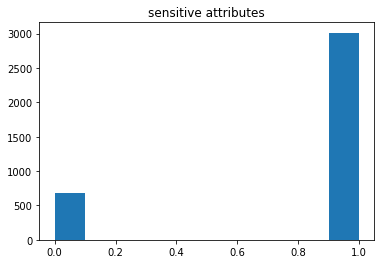

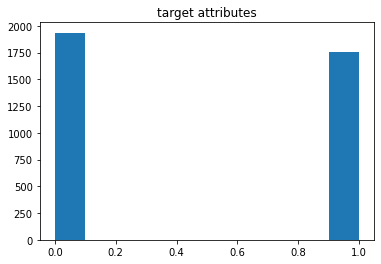

In [5]:
import matplotlib.pyplot as plt
plt.hist(Ztr[:,0])
plt.title("sensitive attributes")
plt.show()
plt.hist(ytr)
plt.title("target attributes")
plt.show()

In [6]:
zy = Ztr + 2*ytr

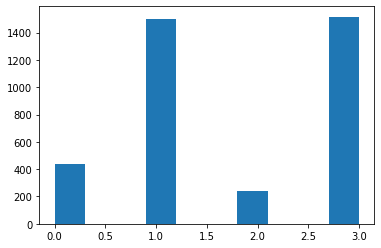

In [7]:
plt.hist(zy[:,0])
plt.show()

- 위의 Graph 를 보면, z 와 y 의 correlation 이 굉장히 높음을 확인할 수 있음

In [8]:
print("sensitive ratio: ",sum(Ztr==0)/len(Ztr))
print("training default: ", sum(ytr==0)/len(ytr))
print("test default: ", sum(yte==0)/len(yte))

sensitive ratio:  [0.18462371]
training default:  [0.52409312]
test default:  [0.54229798]


In [9]:
print('# training samples:', Xtr.shape)
print('# test samples:', Xte.shape)
print('# sensitive vars', Ztr.shape)
print('# output vars', ytr.shape)

# training samples: (3694, 7)
# test samples: (1584, 7)
# sensitive vars (3694, 1)
# output vars (3694, 1)


In [67]:
N1 = 100
Xtr1 = Xtr[:N1]
ytr1 = ytr[:N1]
Ztr1 = Ztr[:N1]
Xtr2 = Xtr[N1:]
ytr2 = ytr[N1:]
Ztr2 = Ztr[N1:]

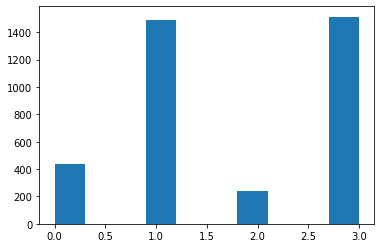

In [68]:
zy2 = Ztr2 + 2*ytr2
plt.hist(zy2[:,0])
plt.show()

In [12]:
np.unique(Ztr)

array([0, 1])

In [13]:
Ztr.shape

(3694, 1)

In [14]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [15]:
from fairNN_train import *
from load_data import *

In [58]:
class Args:
    def __init__(self):
        self.epochs = 30
#         self.max_epochs = None
        self.AL_iters = 100 # AL batch 몇 번 뽑는지?
        self.AL_batch = 2 # AL 시에 select 되는 데이터 수
        self.batch_size = 32
        self.AL_select = 'loss'
        
    def print_args(self):
        print("train epochs/batch: {}/{}".format(self.epochs,self.batch_size))
        print("AL iters/batch: {}/{}".format(self.AL_iters,self.AL_batch))
        print("AL selection is based on ", self.AL_select)

In [59]:
args = Args()

In [60]:
train_data = NPsDataSet(Xtr1, ytr1, Ztr1)
train_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=True, drop_last=True)

In [61]:
from fair_eval import *

In [62]:
zZtr2 = transform_dum2cat(Ztr2)
select_data = NPsDataSet(Xtr2, ytr2, zZtr2)
select_loader = DataLoader(select_data, batch_size=args.batch_size, shuffle=False, drop_last=False)

In [63]:
test_data = NPsDataSet(Xte, yte, Zte)
test_loader = DataLoader(test_data, batch_size=args.batch_size, shuffle=False, drop_last=False)

- gradient calculation for unlabeled set
- expectation 
- https://discuss.pytorch.org/t/how-to-efficiently-compute-gradient-for-each-training-sample/60001/2 
- https://github.com/cybertronai/autograd-hacks#per-example-gradients 
- https://tutorials.pytorch.kr/intermediate/tensorboard_tutorial.html

# Group Selection Part

## Test Group Performance

## find examples for the worst group

In [64]:
from fairAL_utils import *

In [65]:
train_loader.dataset.tensors[0].size(0)

100

## retraining models

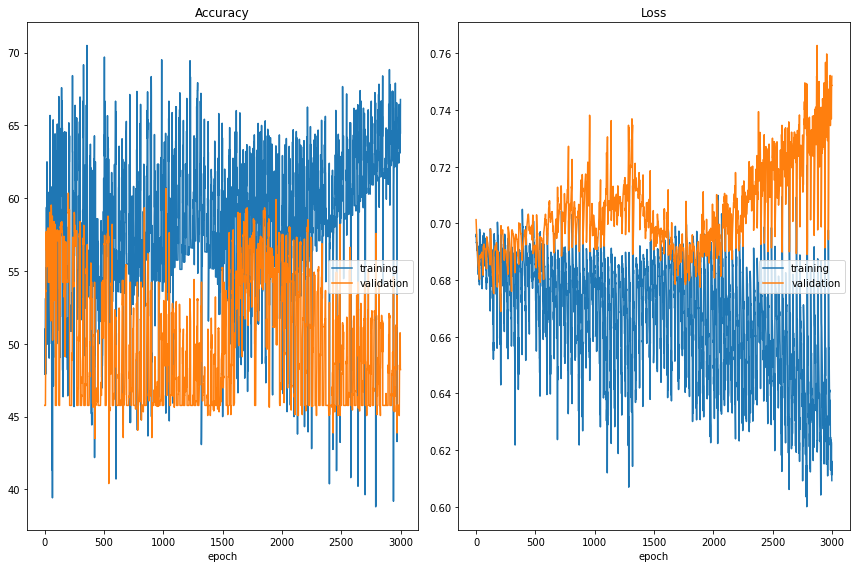

Accuracy
	training         	 (min:   38.811, max:   70.492, cur:   66.779)
	validation       	 (min:   40.404, max:   60.669, cur:   48.232)
Loss
	training         	 (min:    0.600, max:    0.723, cur:    0.609)
	validation       	 (min:    0.669, max:    0.763, cur:    0.752)
Finished Training
0.0 : loss 0.5962223410606384 / acc 70.0
0 tensor(0.5962) 0.0 0.0
1.0 : loss 0.6082640886306763 / acc 66.12903594970703
tensor(0.5962) tensor(0.6083) 0.0 1.0


In [66]:
clf,f_train,f_select = train_AL(train_loader, select_loader, device, args, test_loader, from_scratch = True, random_sel = False)

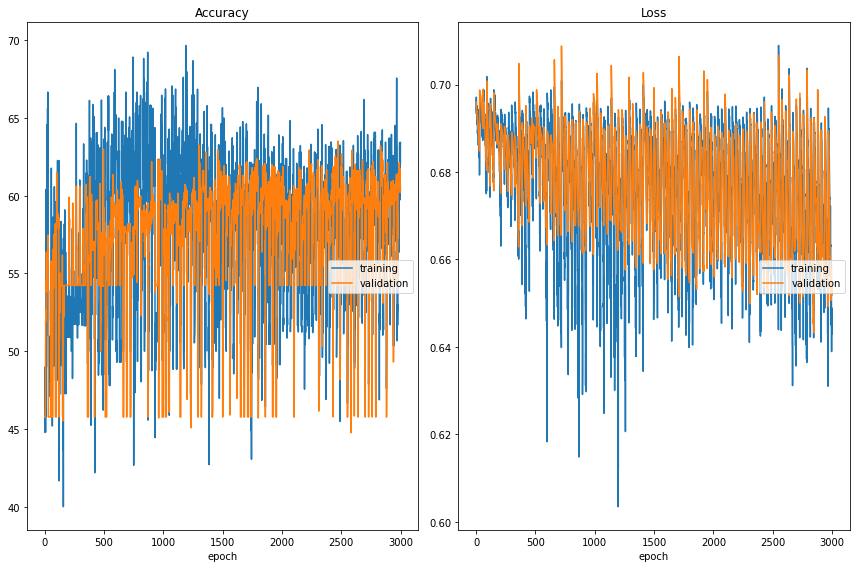

Accuracy
	training         	 (min:   40.000, max:   69.663, cur:   63.423)
	validation       	 (min:   44.760, max:   63.510, cur:   60.227)
Loss
	training         	 (min:    0.603, max:    0.709, cur:    0.643)
	validation       	 (min:    0.643, max:    0.709, cur:    0.655)
Finished Training
0.0 : loss 0.5400456786155701 / acc 74.54545593261719
0 tensor(0.5400) 0.0 0.0
1.0 : loss 0.6567284464836121 / acc 59.670780181884766
tensor(0.5400) tensor(0.6567) 0.0 1.0


In [69]:
clf2,_,_ = train_AL(train_loader, select_loader, device, args, test_loader, from_scratch = True, random_sel = True)

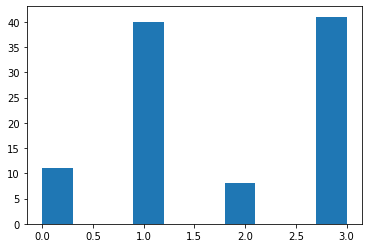

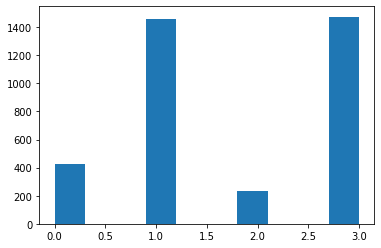

In [36]:
zy1 = train_loader.dataset.tensors[2] + 2*train_loader.dataset.tensors[1]
plt.hist(zy1[:,0])
plt.show()
zy2 = select_loader.dataset.tensors[2] + 2*select_loader.dataset.tensors[1]
plt.hist(zy2[:,0])
plt.show()

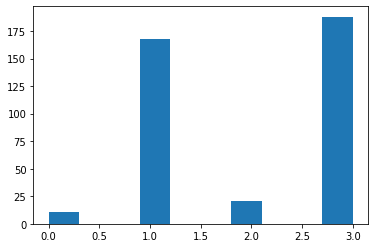

In [37]:
zy3 = f_train.dataset.tensors[2] + 2*f_train.dataset.tensors[1]
plt.hist(zy3[:,0])
plt.show()

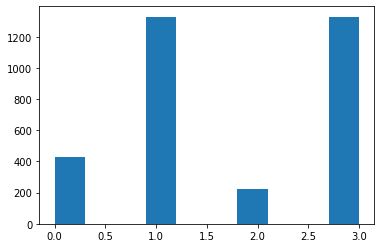

In [38]:
zy3 = f_select.dataset.tensors[2] + 2*f_select.dataset.tensors[1]
plt.hist(zy3[:,0])
plt.show()

In [41]:
clf_criterion = nn.BCELoss()
print("training performances")
test_groupwise(clf,train_loader, clf_criterion, device,args)
print(test_model(clf, train_loader, clf_criterion, device))
print("test performances")
test_groupwise(clf,test_loader, clf_criterion, device,args)
print(test_model(clf, test_loader, clf_criterion, device))
print("select performances")
test_groupwise(clf,select_loader, clf_criterion, device,args)
print(test_model(clf, select_loader, clf_criterion, device))

training performances
0.0 : loss 0.6311430931091309 / acc 63.157894134521484
0 tensor(0.6311) 0.0 0.0
1.0 : loss 0.8637977838516235 / acc 54.320987701416016
tensor(0.6311) tensor(0.8638) 0.0 1.0
(tensor(0.8118), tensor(57.2917))
test performances
0.0 : loss 0.8866857290267944 / acc 44.4126091003418
0 tensor(0.8867) 0.0 0.0
1.0 : loss 0.818304181098938 / acc 55.78947448730469
tensor(0.8867) tensor(0.8183) 0.0 1.0
(tensor(0.8334), tensor(53.2828))
select performances
0.0 : loss 0.8906304240226746 / acc 41.779788970947266
0 tensor(0.8906) 0.0 0.0
1.0 : loss 0.8645161986351013 / acc 53.29239273071289
tensor(0.8906) tensor(0.8645) 0.0 1.0
(tensor(0.8693), tensor(51.1686))


In [40]:
clf_criterion = nn.BCELoss()
print("training performances")
test_groupwise(clf2,train_loader, clf_criterion, device,args)
print(test_model(clf2, train_loader, clf_criterion, device))
print("test performances")
test_groupwise(clf2,test_loader, clf_criterion, device,args)
print(test_model(clf2, test_loader, clf_criterion, device))
print("select performances")
test_groupwise(clf2,select_loader, clf_criterion, device,args)
print(test_model(clf2, select_loader, clf_criterion, device))

training performances
0.0 : loss 0.6433472037315369 / acc 63.157894134521484
0 tensor(0.6433) 0.0 0.0
1.0 : loss 0.6445794105529785 / acc 59.25925827026367
tensor(0.6433) tensor(0.6446) 0.0 1.0
(tensor(0.6514), tensor(58.3333))
test performances
0.0 : loss 0.6331877112388611 / acc 63.610313415527344
0 tensor(0.6332) 0.0 0.0
1.0 : loss 0.6538843512535095 / acc 59.27125549316406
tensor(0.6332) tensor(0.6539) 0.0 1.0
(tensor(0.6493), tensor(60.2273))
select performances
0.0 : loss 0.6532241106033325 / acc 59.879337310791016
0 tensor(0.6532) 0.0 0.0
1.0 : loss 0.6601974368095398 / acc 58.887752532958984
tensor(0.6532) tensor(0.6602) 0.0 1.0
(tensor(0.6589), tensor(59.0707))


# Inspect Methods

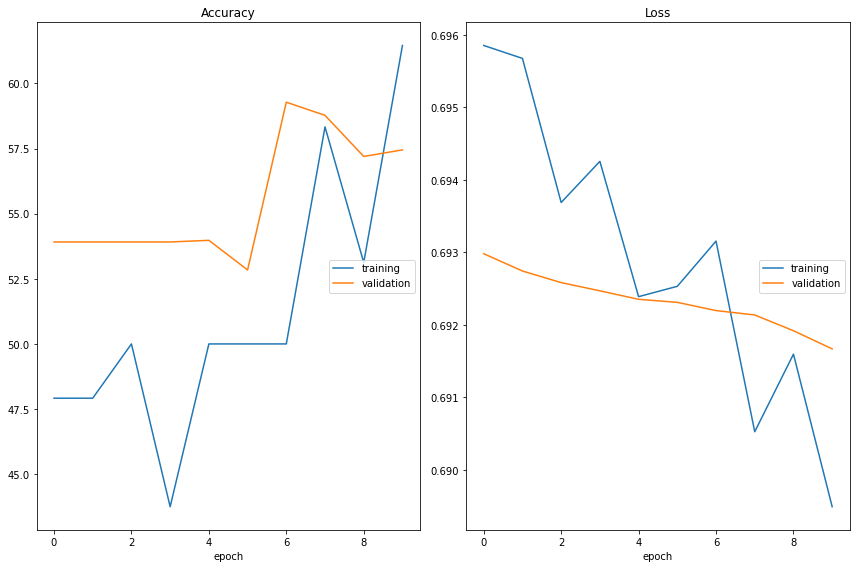

Accuracy
	training         	 (min:   43.750, max:   61.458, cur:   61.458)
	validation       	 (min:   52.841, max:   59.280, cur:   57.449)
Loss
	training         	 (min:    0.689, max:    0.696, cur:    0.689)
	validation       	 (min:    0.692, max:    0.693, cur:    0.692)
Finished Training


In [19]:
# from fairNN_train import *
epochs = 10
n_features = train_loader.dataset.tensors[0].shape[1]
clf = Classifier(n_features=n_features)
clf.cuda()
clf_criterion = nn.BCELoss()
clf_optimizer = optim.Adam(clf.parameters())
train_model(clf, train_loader, clf_criterion, clf_optimizer, device, epochs, test_loader, None)

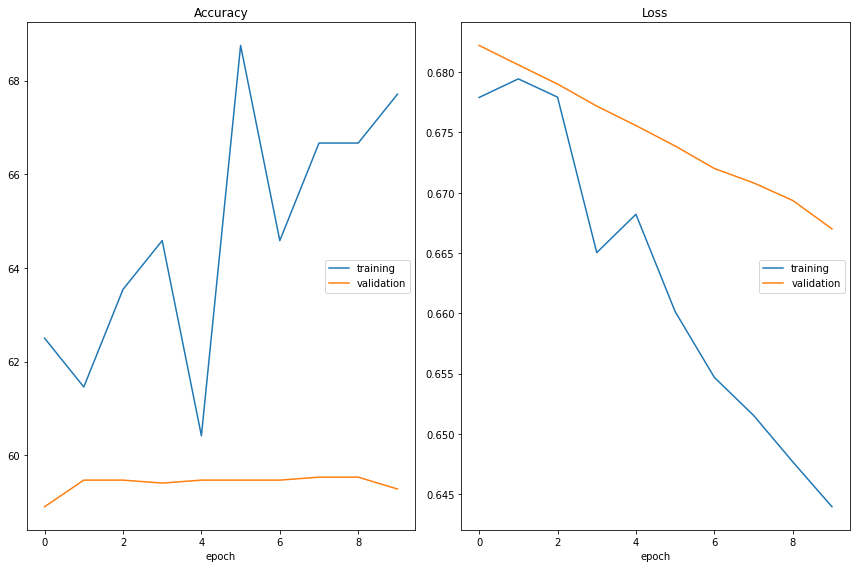

Accuracy
	training         	 (min:   60.417, max:   68.750, cur:   67.708)
	validation       	 (min:   58.902, max:   59.533, cur:   59.280)
Loss
	training         	 (min:    0.644, max:    0.679, cur:    0.644)
	validation       	 (min:    0.667, max:    0.682, cur:    0.667)
Finished Training


In [21]:
train_model(clf, train_loader, clf_criterion, clf_optimizer, device, 10, test_loader, None)

In [57]:
def test_groupwise(clf, data_loader, clf_criterion, device,args):
    dlTensors = data_loader.dataset.tensors
    dldic = divide_groupsDL(dlTensors[0],dlTensors[1],dlTensors[2])
    losss = 0
    accs = 0
    sid = list(dldic.keys())[0]
    for did in dldic.keys():
        loss_v, acc_v = test_model_noz(clf, dldic[did],clf_criterion, device)
        print("{} : loss {} / acc {}".format(did, loss_v, acc_v))
        if args.AL_select == 'loss':
#             print(losss,loss_v,sid,did)
            if losss < loss_v:
                sid = did
                losss = loss_v
        else:
            assert args.AL_select == 'acc'
            if accs > acc_v:
                sid = did
                accs = acc_v
    return sid, dldic


In [49]:
def cal_meangrad(clf, dataloader, criterion, device,normalize=True):
    
    for i,(x,y) in enumerate(dataloader):
        x = x.to(device)
        y = y.to(device)
        clf.zero_grad()
        outs = clf(x)
        criterion(outs,y).backward()
        tmp = []
        for param in clf.parameters():
            tmp.append(param.grad.flatten())
        grads_t = torch.cat(tmp)
        if i==0:
            grads = grads_t
        else:
            grads += grads_t
    prgrad_n = torch.norm(grads)
    if normalize:
        grads /= prgrad_n
    grads = grads.detach().cpu()
    return grads

In [51]:
sid, dldic = test_groupwise(clf, train_loader, clf_criterion, device, args)
grads = cal_meangrad(clf, dldic[sid], clf_criterion, device,False)
ses,sidx = select_examples(clf, select_loader, clf_criterion, grads,device, args.AL_batch)

0.0 : loss 0.6311430931091309 / acc 63.157894134521484
0 tensor(0.6311) 0.0 0.0
1.0 : loss 0.8637977838516235 / acc 54.320987701416016
tensor(0.6311) tensor(0.8638) 0.0 1.0


In [54]:
grads0 = cal_meangrad(clf, dldic[0], clf_criterion, device,False)
grads1 = cal_meangrad(clf, dldic[1], clf_criterion, device,False)

In [57]:
print(grads0)
print(grads1)
print(torch.matmul(grads0,grads1))
print(torch.matmul(grads0,grads0))
print(torch.matmul(grads1,grads1))
print(sid)

tensor([0.0000, 0.0000, 0.0000,  ..., 0.0410, 0.0302, 0.1247])
tensor([ 0.0000,  0.0000,  0.0000,  ..., -0.2152, -0.1927, -0.0053])
tensor(-0.0653)
tensor(0.1797)
tensor(2.5368)
1.0


In [45]:
pred = clf(ses[0].to(device))

In [46]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [47]:
confusion_matrix(ses[1][:,0],(pred>0.5).float().detach().cpu().numpy()[:,0])

array([[ 0,  5],
       [27,  0]])

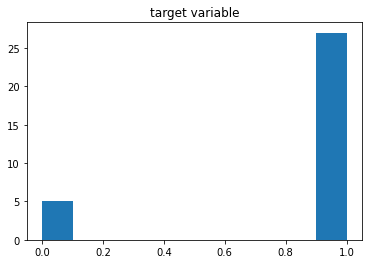

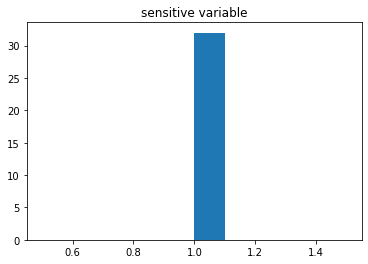

In [48]:
plt.title("target variable")
plt.hist(ses[1][:,0])
plt.show()
plt.title("sensitive variable")
plt.hist(ses[2][:,0])
plt.show()

torch.Size([32, 1])